# Trading Strategy Reconstruction: <Strategy Name>


## Introduction
Briefly describe the trading strategy. Mention the academic paper it comes from, the authors, and the main premise of the strategy.


## Background

#### Theory
Provide a summary or key points from the academic paper. This might include:
- Assumptions made in the paper.
- The theoretical foundation of the strategy.
- Any supporting or opposing views from other academics or practitioners.

#### Key Concepts
Present and explain key formulas or concepts from the paper. This might include algorithm pseudocode, mathematical formulas, or other theoretical concepts vital to understanding the strategy.

## Data Acquisition and Cleaning

#### Data Sources
Discuss the data sources used, e.g., Yahoo Finance, proprietary databases, etc.

#### Data Retrieval
Include code cells that fetch the data. If you're using `yfinance`, show how you're fetching the data.

In [11]:
# Step 1: Install necessary packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [20]:
def download_data(tickers, start_date, end_date):
    try:
        # Download the historical data using the yfinance library
        df = yf.download(tickers, start=start_date, end=end_date, group_by='tickers')
        # Rename the 'Adj Close' column to 'Adj_Close'
        df.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)
        return df
    except Exception as e:
        print(f"Error occurred while trying to download data: {e}")
        return None

futures_codes = ["CL=F", "NG=F"]
start_date = "2010-01-01"
end_date = "2019-12-31"

historical_data = download_data(futures_codes, start_date, end_date)

def null_check_and_clean(df):
    if df.isnull().sum().sum() > 0:
        null_columns = df.columns[df.isnull().any()]
        print("Null value count by column:")
        print(df[null_columns].isnull().sum())
        print("\nRows with null values:")
        print(df[df.isnull().any(axis=1)][null_columns])
        df.dropna(inplace=True)
        print("\nNull values dropped.")
    else:
        print("\nNo null values in dataframe.")
    return df

def check_data_length(df):
    lengths = {ticker: len(data) for ticker, data in df.items()}
    length_set = set(lengths.values())
    if len(length_set) > 1:
        print("Data lengths are not equal!")
        for ticker, length in lengths.items():
            print(f"Length of data for {ticker}: {length}")
    else:
        print(f"All data series have the same length: {next(iter(length_set))}")

historical_data = null_check_and_clean(historical_data)
check_data_length(historical_data)

def create_df(df):
    # Create a new dataframe with only close prices
    close_prices = pd.DataFrame()
    
    # Check if the dataframe has a MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        for ticker in df.columns.levels[0]:
            close_prices[ticker] = df[ticker]['Close']
    else:
        # Ensure 'Close' column exists in the dataframe
        if 'Close' in df.columns:
            close_prices = df[['Close']]
        else:
            raise KeyError("The dataframe doesn't have a 'Close' column.")
    
    return close_prices

print(historical_data)
close_prices =create_df(historical_data)


[*********************100%***********************]  2 of 2 completed

No null values in dataframe.
All data series have the same length: 2513
             NG=F                                              CL=F  \
             Open   High    Low  Close Adj_Close  Volume       Open   
Date                                                                  
2010-01-04  5.705  5.894  5.705  5.884     5.884   78858  79.629997   
2010-01-05  5.837  5.858  5.615  5.637     5.637   99492  81.629997   
2010-01-06  5.690  6.075  5.650  6.009     6.009  140611  81.430000   
2010-01-07  6.033  6.108  5.763  5.806     5.806  135113  83.199997   
2010-01-08  5.827  5.853  5.621  5.749     5.749  101153  82.650002   
...           ...    ...    ...    ...       ...     ...        ...   
2019-12-23  2.254  2.269  2.192  2.214     2.214  127886  60.410000   
2019-12-24  2.202  2.223  2.162  2.172     2.172   49762  60.630001   
2019-12-26  2.184  2.297  2.184  2.294     2.294   53813  61.200001   
2019-1

In [21]:
for ticker in futures_codes:
    print(close_prices[ticker])

print(close_prices.index)
    

Date
2010-01-04    81.510002
2010-01-05    81.769997
2010-01-06    83.180000
2010-01-07    82.660004
2010-01-08    82.750000
                ...    
2019-12-23    60.520000
2019-12-24    61.110001
2019-12-26    61.680000
2019-12-27    61.720001
2019-12-30    61.680000
Name: CL=F, Length: 2513, dtype: float64
Date
2010-01-04    5.884
2010-01-05    5.637
2010-01-06    6.009
2010-01-07    5.806
2010-01-08    5.749
              ...  
2019-12-23    2.214
2019-12-24    2.172
2019-12-26    2.294
2019-12-27    2.158
2019-12-30    2.186
Name: NG=F, Length: 2513, dtype: float64
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns

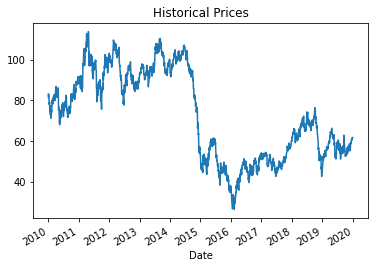

ADF Statistic: -1.4536854015689489
p-value: 0.5562855865601427
Data is not stationary


<Figure size 2160x2160 with 0 Axes>

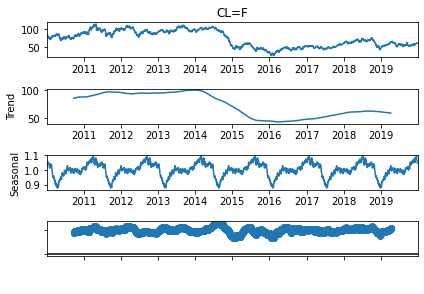

<Figure size 864x432 with 0 Axes>

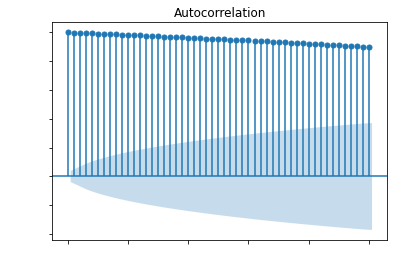

In [30]:


# Assuming `prices` is your time series of historical price data
# For the purpose of this example, we'll generate some synthetic data
np.random.seed(42)
dates = close_prices.index
prices = close_prices['CL=F']
prices_series = pd.Series(prices, index=dates)

# 1. Plot the data
prices_series.plot(title='Historical Prices')
plt.show()

# 2. Test for stationarity using ADF
result = adfuller(prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

# 3. Decompose the series
plt.figure(figsize=(30,30))
decomposition = seasonal_decompose(prices_series, model='multiplicative', period=365)
decomposition.plot()
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Component Value', color='white')
plt.show()

# 4. ACF plot
plt.figure(figsize=(12, 6))
plot_acf(prices, lags=50)
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Lag', color='white')
plt.ylabel('Autocorrelation', color='white')
plt.show()


In [2]:
# Step 1: Install necessary packages
import yfinance as yf
import pandas as pd
import numpy as np

# Step 2: Load historical stock price data
def load_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    return data['Adj Close']

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN'] # Example tickers, you can add more
start_date = '2020-01-01'
end_date = '2021-01-01'
prices = load_data(tickers, start_date, end_date)

# Step 3: Form pairs based on cumulative return over the formation period
def form_pairs(data, formation_period=252):
    returns = data.pct_change().dropna()
    cumulative_returns = (returns + 1).cumprod()
    distance_matrix = np.zeros((len(data.columns), len(data.columns)))
    
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            if i != j:
                distance_matrix[i, j] = np.sum((cumulative_returns.iloc[-formation_period:, i] - cumulative_returns.iloc[-formation_period:, j])**2)
            else:
                distance_matrix[i, j] = np.inf
    pairs = []
    for i in range(len(data.columns)):
        j = np.argmin(distance_matrix[i, :])
        if (j, i) not in pairs and (i, j) not in pairs:
            pairs.append((i, j))
    return pairs

pairs = form_pairs(prices)

# Step 4: Implement the trading strategy
def trade_pairs(data, pairs, formation_period=252, trading_period=126, z_threshold=2):
    returns = data.pct_change().dropna()
    cumulative_returns = (returns + 1).cumprod()
    results = []

    for i, j in pairs:
        spread = cumulative_returns.iloc[-trading_period:, i] - cumulative_returns.iloc[-trading_period:, j]
        mean_spread = spread.mean()
        std_spread = spread.std()
        long_entry = spread < mean_spread - z_threshold * std_spread
        short_entry = spread > mean_spread + z_threshold * std_spread
        long_exit = spread > mean_spread
        short_exit = spread < mean_spread
        
        num_positions = long_entry.sum() + short_entry.sum()
        num_converged = (long_entry & long_exit).sum() + (short_entry & short_exit).sum()
        
        results.append((i, j, num_positions, num_converged))

    return results

trading_results = trade_pairs(prices, pairs)

# Step 5: Calculate excess returns
# This is a basic version and needs further implementation based on the given methodology. This step largely depends on your desired metrics and interpretations.

print(trading_results)



[*********************100%***********************]  4 of 4 completed
[(0, 1, 8, 0), (2, 3, 3, 0)]


#### Data Cleaning
Present any steps or transformations you undertake to clean or preprocess the data. This might include handling missing data, outliers, or converting data to a format suitable for backtesting.

## Strategy Construction

#### Pseudocode
Provide a high-level pseudocode or step-by-step approach to the strategy's logic. This helps in understanding and then coding the strategy.

#### Strategy Implementation
The actual Python code that constructs the strategy. This might involve defining trading signals, calculating indicators, or any other computation that forms the strategy's logic.

## Backtesting

#### Setting Parameters
Define any parameters for backtesting - like initial capital, transaction costs, etc.

#### Running the Backtest
Show the code for running the backtest. This might involve looping through the data and applying the strategy logic to make buy/sell decisions.

#### Metrics & Results
Present key performance metrics: 
- Total Return
- Annualized Return
- Maximum Drawdown
- Sharpe Ratio, etc.

## Visualization

Provide visual representations:
- Cumulative returns over time.
- Drawdowns.
- Maybe a comparison with benchmark returns.
- Histogram of returns, etc.

## Conclusion

Summarize the findings:
- Did the strategy perform well?
- How did it compare to a benchmark or to expectations set out in the academic paper?
- Potential improvements or modifications.

## References

- List the academic papers, books, or any other resources referred to in the notebook.